In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2
import yfinance
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from arch import arch_model

from math import sqrt
sns.set()

## Importing the data

In [10]:
# scraping the data off of yahoo finance ,, abbreviation of certian equites in the stock market
# DE indicates this data was from German Stock Market
## BMW.DE ACTS as the benchmark 

raw_data = yfinance.download(tickers="VOW3.DE, PAH3.DE, BMW3.DE", interval='1d', group_by='ticker',
                            auto_adjust=True, treads=True)

[*********************100%***********************]  3 of 3 completed


In [11]:
df = raw_data.copy()

### Defining Key Dates

In [12]:
## start data
start_date = '2009-04-05' # earliest date we have recoreded values for both the stock 

## first official announcement 49.9%
ann_1 = '2009-12-09'

## second official aanoucement 50.1%
ann_2 = '2012-07-05'


## end_date
end_date = '2014-01-01'

# Dieselgate scandal - diesel vechile equipped with flawed s/w to pass enviroinment polllution test
d_gate = '2015-09-20'

### Preprocessing

In [13]:
## extraciting closing price

df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW3.DE'].Close

## creating returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

## creating squared retuens (for volatility)
df['sqret_vol'] = df['ret_vol'].mul(df['ret_vol'])
df['sqret_por'] = df['ret_por'].mul(df['ret_por'])
df['sqret_bmw'] = df['ret_bmw'].mul(df['ret_bmw'])

# extracting volumes (number of purchases and sales each day)
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW3.DE'].Volume

## the more a certian stock is being traded on a certian day the more likely it is for its price to fluctuate

In [15]:
# Assigning the frequency and filling the NA values

df= df.asfreq('b')
df= df.fillna(method='bfill')

In [16]:
## removing surplus data
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW3.DE']

In [17]:
df.head()

,vol,por,bmw,ret_vol,ret_por,ret_bmw,sqret_vol,sqret_por,sqret_bmw,q_vol,q_por,q_bmw
,,,,,,,,,,,,
Date,,,,,,,,,,,,
1998-07-22,33.726032,26.059917,-10.435314,-4.405640,-3.831346,0.000000,19.409661,14.679209,0.000000,56337.0,901567.0,48100.0
1998-07-23,32.240185,26.059917,-10.435314,-4.405640,-3.831346,0.000000,19.409661,14.679209,0.000000,95571.0,901567.0,48100.0
1998-07-24,32.107307,26.059917,-10.435314,-0.412148,-3.831346,0.000000,0.169866,14.679209,0.000000,154423.0,901567.0,33800.0
1998-07-27,31.178852,26.059917,-10.535628,-2.891726,-3.831346,0.961295,8.362079,14.679209,0.924088,62876.0,901567.0,5200.0
1998-07-28,30.435692,26.059917,-10.736305,-2.383539,-3.831346,1.904746,5.681260,14.679209,3.628056,116195.0,901567.0,2600.0


In [18]:
## at this point we usually split the data into trainin and test set,, but since we are not predicitng the future
## rather examining specific event in time 

### Plotting the Prices 

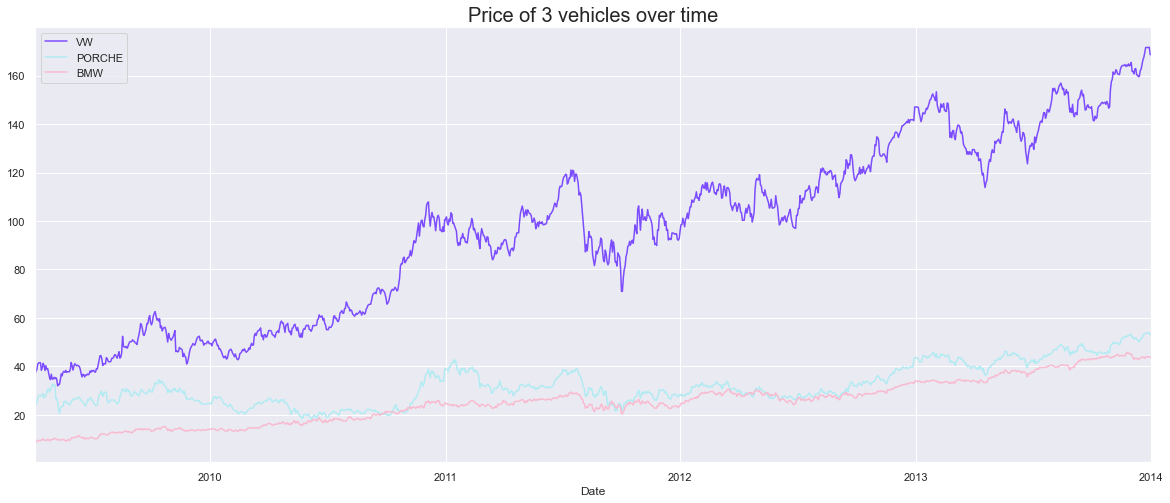

In [23]:
df['vol'][start_date:end_date].plot(figsize=(20,8),color='#7C4DFF')
df['por'][start_date:end_date].plot(color='#B2EBF2')
df['bmw'][start_date:end_date].plot(color='#F8BBD0')
plt.title('Price of 3 vehicles over time',size=20)
plt.legend(['VW','PORCHE','BMW'])
plt.show()

In [22]:
## we can see some similarity in the way they move ,, which indicates the trends of entire automobile industry market
## VW price has shift a lot in magnitude after the 3rd quarter of 2009

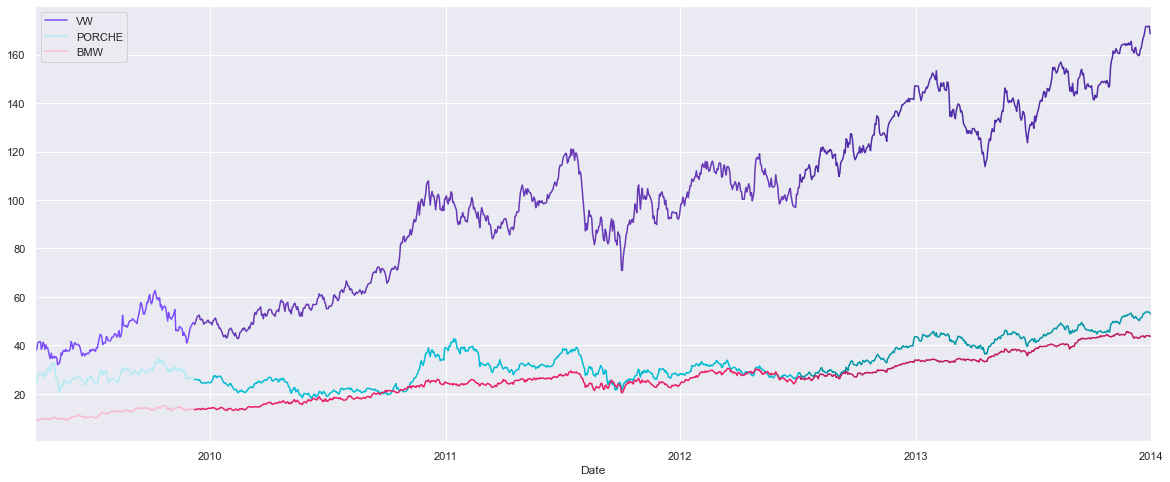

In [25]:
## shades of blue #7C4DFF' '#673AB7' '#512DA8' '
# sdhades of cyan "#B2EBF2" "#00BCD4" "#0097A7"
# shades of red "#F8BBD0" "#E91E63" "#C2185B"

df['vol'][start_date:ann_1].plot(figsize=(20,8),color='#7C4DFF')
df['por'][start_date:ann_1].plot(color='#B2EBF2')
df['bmw'][start_date:ann_1].plot(color='#F8BBD0')

df['vol'][ann_1:ann_2].plot(figsize=(20,8),color='#673AB7')
df['por'][ann_1:ann_2].plot(color='#00BCD4')
df['bmw'][ann_1:ann_2].plot(color='#E91E63')

df['vol'][ann_2:end_date].plot(figsize=(20,8),color='#512DA8')
df['por'][ann_2:end_date].plot(color='#0097A7')
df['bmw'][ann_2:end_date].plot(color='#C2185B')


plt.legend(['VW','PORCHE','BMW'])
plt.show()



In [27]:
# prior to th first announcement, the two stock BMW and porsche move in a similar fashion however vw number seems to 
## be roughly 2X as high
## aftwerwards the gap between the 2 seems to grow bigger and bigger 
## BMW number resemble porsche number much closer than VW ones
## to see their resemblance to each other, let us see their correlation

### Correlation

In [28]:
print('coorelation among manufacturers from '+str(start_date)+"to"+str(end_date)+"\n")
print('VW and porsche correlation: '+str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('VW and BMW correaltion: '+ str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('BMW and Porsche correlaiton: '+str(df['bmw'][start_date:end_date].corr(df['por'][start_date:end_date])))


coorelation among manufacturers from 2009-04-05to2014-01-01

VW and porsche correlation: 0.8348050084649205
VW and BMW correaltion: 0.9739645402510853
BMW and Porsche correlaiton: 0.8355724127355171


In [29]:
## we see more correlation between VW and BMW than any other two combination 
## shows, VW moves in a similar way to the market benchmark although the magnitude is high 

In [30]:
## VW owns 100 of Porsche at the end of the time interval,, should not their correlaiton be much higher?? 
## let us examine the 3 interval 1 at atime


In [32]:
print('coorelation among manufacturers from '+str(start_date)+"to"+str(ann_1)+"\n")
print('VW and porsche correlation: '+str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('VW and BMW correaltion: '+ str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('BMW and Porsche correlaiton: '+str(df['bmw'][start_date:ann_1].corr(df['por'][start_date:ann_1])))

coorelation among manufacturers from 2009-04-05to2009-12-09

VW and porsche correlation: 0.6633400945227693
VW and BMW correaltion: 0.8563877608924034
BMW and Porsche correlaiton: 0.5907332261251685


In [35]:
## the stock price of these brands(vw and porcshe) were not too similar before the start of the buyout 

In [33]:
print('coorelation among manufacturers from '+str(ann_1)+"to"+str(ann_2)+"\n")
print('VW and porsche correlation: '+str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('VW and BMW correaltion: '+ str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('BMW and Porsche correlaiton: '+str(df['bmw'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))

coorelation among manufacturers from 2009-12-09to2012-07-05

VW and porsche correlation: 0.7422114342529966
VW and BMW correaltion: 0.9785265807976127
BMW and Porsche correlaiton: 0.6680349520988501


In [34]:
print('coorelation among manufacturers from '+str(ann_2)+"to"+str(end_date)+"\n")
print('VW and porsche correlation: '+str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('VW and BMW correaltion: '+ str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('BMW and Porsche correlaiton: '+str(df['bmw'][ann_2:end_date].corr(df['por'][ann_2:end_date])))

coorelation among manufacturers from 2012-07-05to2014-01-01

VW and porsche correlation: 0.9405237308477341
VW and BMW correaltion: 0.8564006541351125
BMW and Porsche correlaiton: 0.928673852917518


In [36]:
## after vw buys porsche, two are being recognized as the single entity and prices of one direclty affects the other 
## also , BMW and Porsche are highly correlated which is interesting considering they have no obvious link 
## VW become the market trend setter --> affects prices of porcshe direclty and vw indirectly 

In [37]:
## what happens after the end date

In [39]:
print('coorelation among manufacturers from '+str(end_date)+"to"+str(df.index[-1])+"\n")
print('VW and porsche correlation: '+str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('VW and BMW correaltion: '+ str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('BMW and Porsche correlaiton: '+str(df['bmw'][end_date:].corr(df['por'][end_date:])))

coorelation among manufacturers from 2014-01-01to2021-01-21 00:00:00

VW and porsche correlation: 0.9377677545702415
VW and BMW correaltion: 0.24413531126190188
BMW and Porsche correlaiton: 0.29319249838896305


In [40]:
# corr betwn VW and porsche remain high while, remaining has dropped drastically 
## if there was another boom in th VW prices it would once again lead the market with it but this has not appeared to
## be the case ... but what did actually happen??


## the dieselgate scandal effect :

## to examine how it affect the corealtion between prices ... comment on the result

### Best Fitting Model

In [41]:
### to capture the current trend of the market ,, but if the trend shifts so should they
## let us see how VW trends changed after the 2 annoucements

In [43]:
model_pr_pre_vol = auto_arima(df.vol[start_date:ann_1],exogenous= df[['por','bmw']][start_date:ann_1],m=5, max_p=5, max_q=5)
model_pr_bet_vol = auto_arima(df.vol[ann_1:ann_2],exogenous= df[['por','bmw']][ann_1:ann_2],m=5, max_p=5, max_q=5)
model_pr_post_vol = auto_arima(df.vol[ann_2:end_date],exogenous= df[['por','bmw']][ann_2:end_date],m=5, max_p=5, max_q=5)



In [44]:
model_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -322.555
Date:                Fri, 22 Jan 2021   AIC                            655.111
Time:                        12:26:27   BIC                            671.020
Sample:                    04-06-2009   HQIC                           661.562
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8592      0.482      1.782      0.075      -0.086       1.804
por            0.4123      0.102      4.036      0.000       0.212       0.612
bmw            1.0913      0.487      2.242      0.025       0.137       2.045
ar.L1          0.9574      0.022     44.174      0.000       0.915       1.000
sigma2         2.1649      0.141     15.321      0.000       1.888       2.442
===================================================================================
Ljung-Box (Q):                       36.78   Jarque-Bera (JB):               197.73
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                            -0.62
Prob(H) (two-sided):                  0.07   Kurtosis:                         8.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
## for period prior to 49.9 pecent announcement we see that an AR model with a single lag and 2 exog. valriable
## is the best fit 
## all coeff apart from coeff is significant thus this is indeed a good fit 
## estimate for ar vaue is very close to 1 (0.95) -- we re sticking very close to the value of the last period with
## very little deviation -- this is because we are using prices that dont oscillate completely randomly 

In [46]:
model_pr_bet_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1133.607
Date:                Fri, 22 Jan 2021   AIC                           2281.214
Time:                        12:30:34   BIC                           2312.786
Sample:                    12-09-2009   HQIC                          2293.442
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.0894      0.061     17.975      0.000       0.971       1.208
bmw            2.1576      0.129     16.772      0.000       1.905       2.410
ar.L1          0.2440      0.183      1.334      0.182      -0.114       0.602
ar.L2          0.7465      0.180      4.146      0.000       0.394       1.099
ma.L1          0.7219      0.179      4.042      0.000       0.372       1.072
ma.L2         -0.0806      0.036     -2.217      0.027      -0.152      -0.009
sigma2         1.6978      0.069     24.493      0.000       1.562       1.834
===================================================================================
Ljung-Box (Q):                       35.91   Jarque-Bera (JB):               122.78
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
## for in between period ARIMAX(2,0,2) 
## DATA is still stationary,, thus we are not going for integrated model
## here we are acconting for ar(2)-- values 2 lags prior  and ma(2)-- error terms 2 lags prior

In [48]:
model_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -622.416
Date:                Fri, 22 Jan 2021   AIC                           1250.832
Time:                        12:34:38   BIC                           1262.722
Sample:                    07-05-2012   HQIC                          1255.546
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            2.0669      0.060     34.647      0.000       1.950       2.184
bmw            0.9466      0.166      5.708      0.000       0.622       1.272
sigma2         1.4365      0.074     19.543      0.000       1.292       1.581
===================================================================================
Ljung-Box (Q):                       26.45   Jarque-Bera (JB):                68.98
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.31
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
## we see that the model has cahnged completelty one more time
## we are recognizing the non-stationary nature of stock prices .. since stationary model is being used 
## we are no longer relying on past values 
## we can see huge shift of coefficeints for porsche prices (2.0669)
## this shifts occur because the two automobile company are now the single entity 
## thus the price of Porcshe today will be a more accurate estimate than the prices of VW yesterday (important point)


## this new information tends to have higher impact on trends compared to past patterns 
## is it true for Porsche as well?

### For Porsche

In [52]:
model_pr_pre_por = auto_arima(df.por[start_date:ann_1],exogenous= df[['vol','bmw']][start_date:ann_1],m=5, max_p=5, max_q=5)
model_pr_bet_por = auto_arima(df.por[ann_1:ann_2],exogenous= df[['vol','bmw']][ann_1:ann_2],m=5, max_p=5, max_q=5)
model_pr_post_por = auto_arima(df.por[ann_2:end_date],exogenous= df[['vol','bmw']][ann_2:end_date],m=5, max_p=5, max_q=5)



In [53]:
model_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  178
Model:             SARIMAX(2, 0, 0)x(0, 0, [1, 2], 5)   Log Likelihood                -218.353
Date:                                Fri, 22 Jan 2021   AIC                            452.705
Time:                                        12:42:28   BIC                            478.160
Sample:                                    04-06-2009   HQIC                           463.028
                                         - 12-09-2009                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4855      0.354      1.372      0.170      -0.208       1.179
vol            0.1248      0.053      2.340      0.019       0.020       0.229
bmw            1.0995      0.252      4.357      0.000       0.605       1.594
ar.L1          1.1059      0.061     18.017      0.000       0.986       1.226
ar.L2         -0.1600      0.061     -2.631      0.009      -0.279      -0.041
ma.S.L5       -0.0984      0.069     -1.429      0.153      -0.233       0.037
ma.S.L10      -0.1224      0.085     -1.434      0.152      -0.290       0.045
sigma2         0.6718      0.052     12.903      0.000       0.570       0.774
===================================================================================
Ljung-Box (Q):                       24.70   Jarque-Bera (JB):               408.91
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
## model discovers seasonal pattern 

In [54]:
model_pr_bet_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -557.536
Date:                Fri, 22 Jan 2021   AIC                           1123.073
Time:                        12:42:51   BIC                           1141.108
Sample:                    12-09-2009   HQIC                          1130.058
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.1982      0.013     15.013      0.000       0.172       0.224
bmw            0.4104      0.063      6.564      0.000       0.288       0.533
ar.L1          0.0890      0.030      2.959      0.003       0.030       0.148
sigma2         0.3085      0.010     32.390      0.000       0.290       0.327
===================================================================================
Ljung-Box (Q):                       35.31   Jarque-Bera (JB):               990.97
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.07
Prob(H) (two-sided):                  0.03   Kurtosis:                         8.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
model_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -196.948
Date:                             Fri, 22 Jan 2021   AIC                            401.897
Time:                                     12:42:54   BIC                            417.751
Sample:                                 07-05-2012   HQIC                           408.182
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.2321      0.012     20.001      0.000       0.209       0.255
bmw            0.3266      0.063      5.178      0.000       0.203       0.450
ma.S.L5       -0.1296      0.058     -2.243      0.025      -0.243      -0.016
sigma2         0.1611      0.006     27.485      0.000       0.150       0.173
===================================================================================
Ljung-Box (Q):                       34.63   Jarque-Bera (JB):               647.37
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
## models discovers seasonal patterns
## these trends are affected more by current events rather than preexisting patterns 

## let us use retuens instead of price s:: for hw 


### predictions for the future

In [ ]:
## prediction for the time periods between the two annoucements based on the trends prior to the first one 

### For Porshe

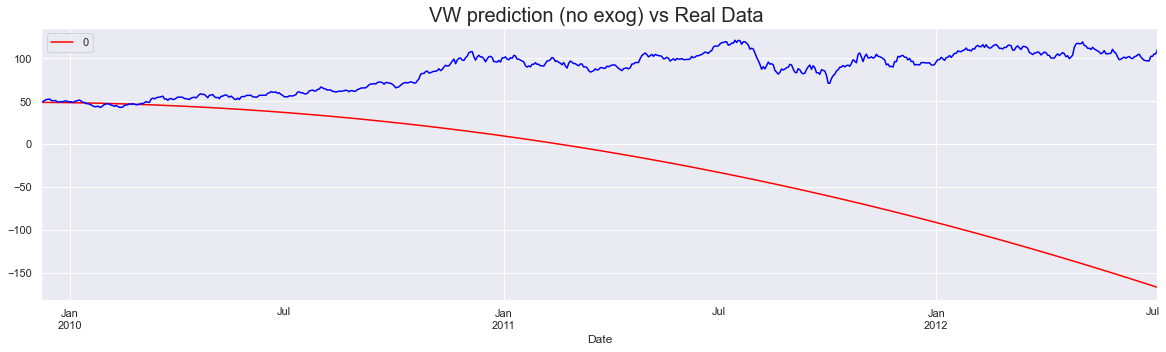

In [60]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1],m=5,max_p=5,max_q=5, max_P=5,max_Q=5,trend='ct')
df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods=len(df[ann_1:ann_2])), index=df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize=(20,5),color='red')

df.vol[ann_1:ann_2].plot(color='blue')
plt.title('VW prediction (no exog) vs Real Data ',size=20)
plt.show()

In [61]:
## peridction seems good over first 3/4 months but starts to die off faster and faster whilt the actual price steadily
## bouces up 
## this indicates that the annocement did not make a great shift in price trends for vw initially -- that can be attributed
## to market lag where new information as well as policy changes takes a while to respond approprately 
## we notice tha tthe forcasted prices are going below 0 which is impossible 

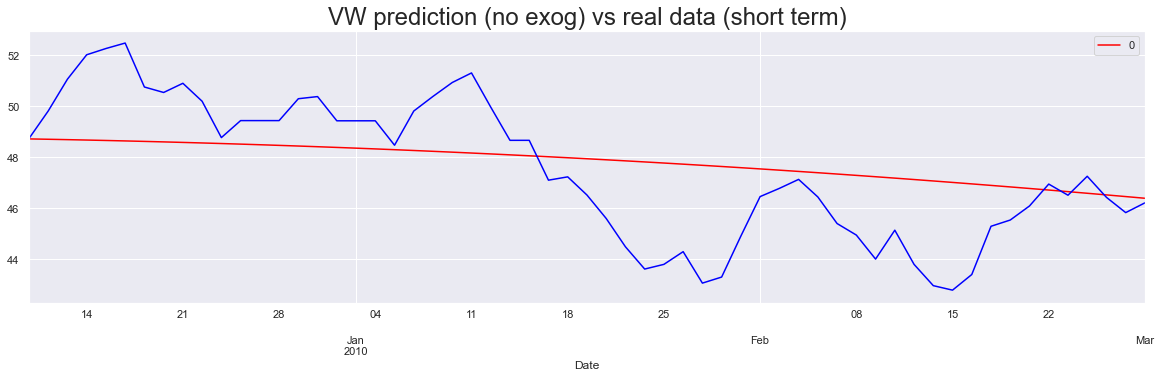

In [62]:
df_auto_pred_pr[ann_1:'2010-03-01'].plot(figsize=(20,5),color='red') ## loking at first quarter after the first annoiucement
df.vol[ann_1:'2010-03-01'].plot(color='blue')
plt.title('VW prediction (no exog) vs real data (short term)',size=24)
plt.show()

In [63]:
## we see that the predictions were not close day by day  but captures the general trend over the entire period
## this shows the prediciton would only be useful if we are trying to "Ballpark" the quarterly performance of prices


In [64]:
## let us see how our model performs if we include exogeneous prices

In [ ]:
## For Volkswagen

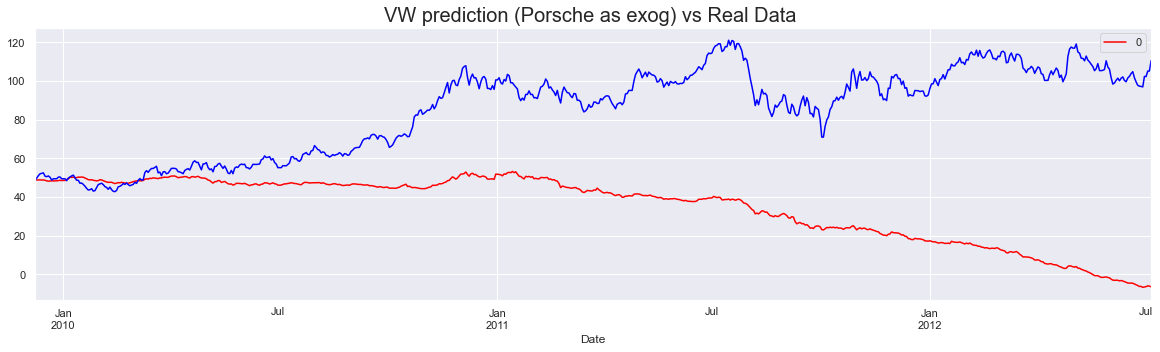

In [67]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1],exogenous= df[['por']][start_date:ann_1],m=5,max_p=5,max_q=5, max_P=5,max_Q=5,trend='ct')
df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods=len(df[ann_1:ann_2]), exogenous=df[['por']][ann_1:ann_2]), index=df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize=(20,5),color='red')

df.vol[ann_1:ann_2].plot(color='blue')
plt.title('VW prediction (Porsche as exog) vs Real Data ',size=20)
plt.show()

In [68]:
## now we see trend that dont simply die off exponentially after several months instead value fluctute within certian
## reasonabel range 
## however after some time the general trend and the lower porsche prices leaves our forcast astray 
## thus adding porsche prices improves predictions but not substantially 

## since we are moving farway from the actual value after q3 of 2010 -- since porsche is ownwd partialy by vw at that point
## using the market benchmark would be the wiser move 

In [69]:
## let us switch exog to bmw

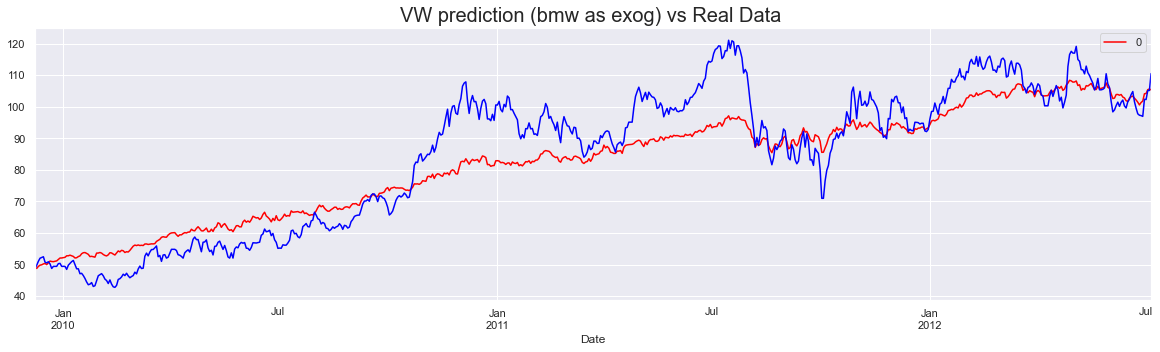

In [71]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1],exogenous= df[['bmw']][start_date:ann_1],m=5,max_p=5,max_q=5, max_P=5,max_Q=5,trend='ct')
df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods=len(df[ann_1:ann_2]), exogenous=df[['bmw']][ann_1:ann_2]), index=df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize=(20,5),color='red')

df.vol[ann_1:ann_2].plot(color='blue')
plt.title('VW prediction (bmw as exog) vs Real Data ',size=20)
plt.show()

In [72]:
## WITH this small alteration we can see that the forcast are linig up with the general trend over the entire period 
## rather than only the forst few months 

## we see that the changes our forcast makes are conservative for both rises and falls 
## in some interval faliure to adjust in some major decrease results in over estiation for a prolong period

## same is true for major jump occuring in q3 of 2010,, our model has underestimate 

## overall these prediction resemble the real movement of the vw eqity much better than the two previous models

In [73]:
## let see ehat happens if we include both exogenous variables

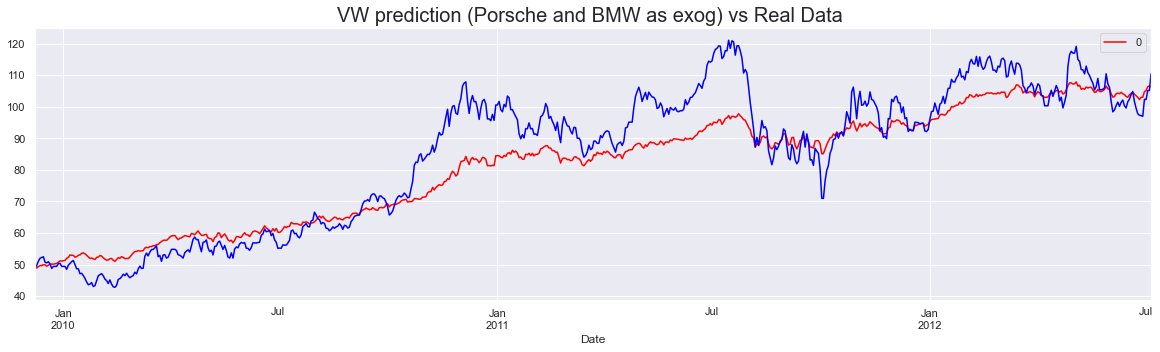

In [74]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1],exogenous= df[['por','bmw']][start_date:ann_1],m=5,max_p=5,max_q=5, max_P=5,max_Q=5,trend='ct')
df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods=len(df[ann_1:ann_2]), exogenous=df[['por','bmw']][ann_1:ann_2]), index=df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize=(20,5),color='red')

df.vol[ann_1:ann_2].plot(color='blue')
plt.title('VW prediction (Porsche and BMW as exog) vs Real Data ',size=20)
plt.show()

In [ ]:
## this is similar to the one using only BMW prices 
## however this matches the smaller shifts better and adjusts to bigger jumps and drops faster
## thus adding a relevent value to a market benchmark we can improve prediction significanlty 

## thus we can say that MAX model are less affected by real life events beacuse the other time series often reflected
## changes in the market and help navigatee expectations 
## however we saw tha tthe general trends changed afer the first annoucemnt even though it tool the price little time
## to reasonably shift in an unpredicted manner 

In [75]:
## let us see the result for the second interval

/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1095: UserWarning: Attempting to set identical left == right == 11090.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


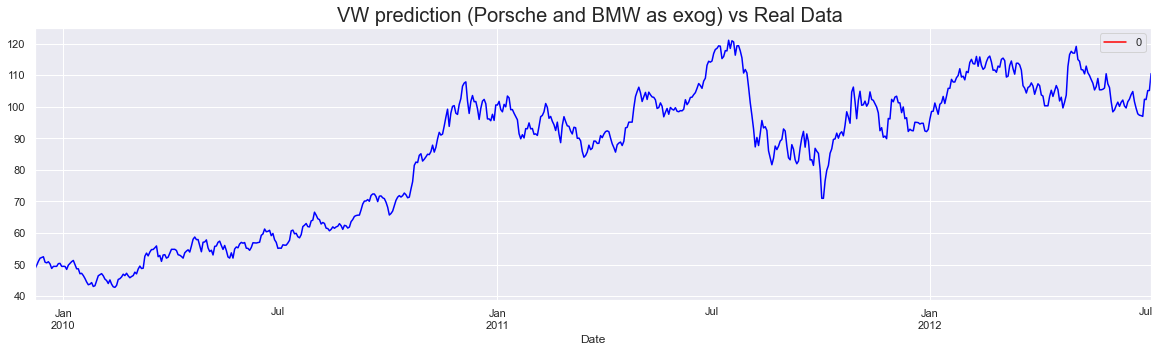

In [77]:
model_auto_pred_pr = auto_arima(df.vol[ann_1:ann_2],exogenous= df[['por','bmw']][ann_1:ann_2],m=5,max_p=5,max_q=5, max_P=5,max_Q=5,trend='ct')
df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods=len(df[ann_2:end_date]), exogenous=df[['por','bmw']][ann_2:end_date]), index=df[ann_2:end_date].index)


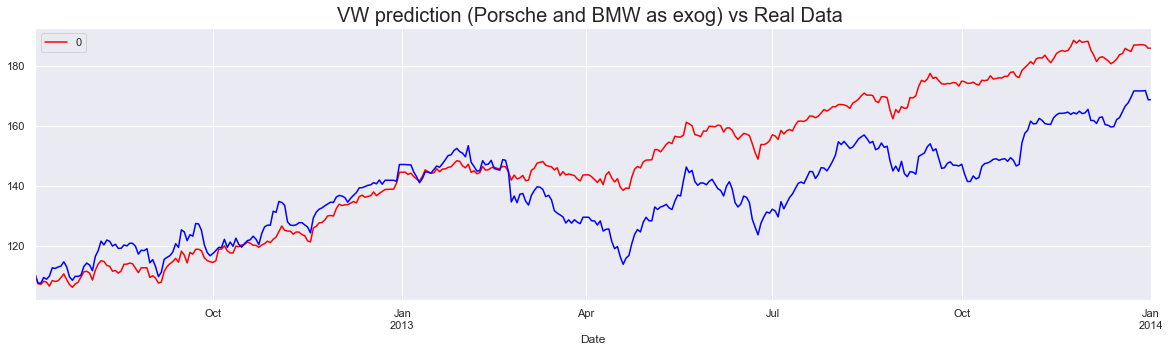

In [79]:
df_auto_pred_pr[ann_2:end_date].plot(figsize=(20,5),color='red')

df.vol[ann_2:end_date].plot(color='blue')
plt.title('VW prediction (Porsche and BMW as exog) vs Real Data ',size=20)
plt.show()

In [80]:
## has captured the trend,, but has iverestimated after the last quarter of april 2013
## may be some thing might have occured then that might have cause the price to go down 

### Volatility

In [81]:
## usually we expect some major shifts surrounding such events 
## square returns represents the volatility of the stock 

In [82]:
### Volatilty of VW for each period

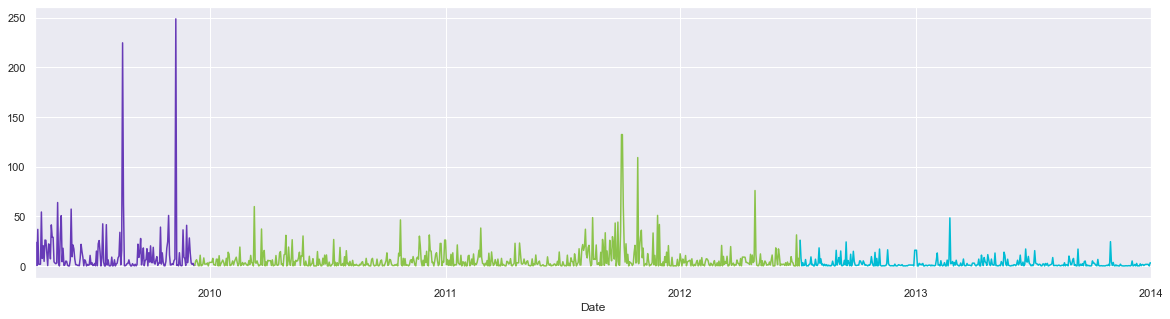

In [84]:
df.sqret_vol[start_date:ann_1].plot(figsize=(20,5), color='#673AB7')
df.sqret_vol[ann_1:ann_2].plot(color='#8BC34A')
df.sqret_vol[ann_2:end_date].plot(color='#00BCD4')
plt.show()

In [ ]:
## we see that that VW has highest volatlty before any annoucements 
## the stock becomes extremrly stable after following each of the two annoucents shile it exhibits instability
## from the time leading to each purchase 

## could be due to rumors spreading in the market about the deal on the horizon

# however when porsche has initially tried to purchase VW a few years back many people were not certain about
## how this would all play out 

## we now that a simple garch_1_1 model should be the best fit for returns

## lets see how variance and residual coeff eveolvs from perid to period 

### Volatility trends for each periods

In [86]:
## we can do this by fitting such a model for every periods and comparing the values from the summary ltable

In [88]:
model_garch_pre = arch_model(df.vol[start_date:ann_1], mean='Constant', vol='GARCH', p=1, q=1)
result_garch_pre = model_garch_pre.fit(update_freq=5)

model_garch_mid = arch_model(df.vol[ann_1:ann_2], mean='Constant', vol='GARCH', p=1, q=1)
result_garch_mid = model_garch_mid.fit(update_freq=5)

model_garch_post = arch_model(df.vol[ann_2:end_date], mean='Constant', vol='GARCH', p=1, q=1)
result_garch_post = model_garch_post.fit(update_freq=5)


Iteration:      5,   Func. Count:     36,   Neg. LLF: 550.0889520046251
Iteration:     10,   Func. Count:     67,   Neg. LLF: 540.9964513766879
Iteration:     15,   Func. Count:     97,   Neg. LLF: 540.994161527799
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 540.994145293055
            Iterations: 16
            Function evaluations: 104
            Gradient evaluations: 16
Iteration:      5,   Func. Count:     34,   Neg. LLF: 2660.2227595478416
Iteration:     10,   Func. Count:     66,   Neg. LLF: 2642.590874819864
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2641.964981191226
            Iterations: 14
            Function evaluations: 90
            Gradient evaluations: 14
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1468.0218188600022
Iteration:     10,   Func. Count:     66,   Neg. LLF: 1451.0166897441127
Iteration:     15,   Func. Count:     96,   Neg. LLF: 1448.6542919425328
O

In [89]:
result_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                      -0.335
Mean Model:             Constant Mean   Adj. R-squared:                 -0.335
Vol Model:                      GARCH   Log-Likelihood:               -540.994
Distribution:                  Normal   AIC:                           1089.99
Method:            Maximum Likelihood   BIC:                           1102.72
                                        No. Observations:                  178
Date:                Fri, Jan 22 2021   Df Residuals:                      174
Time:                        13:48:21   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            40.6836      2.527     16.101  2.496e-58 [ 35.731, 45.636]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.6959      1.104      1.536      0.124 [ -0.468,  3.860]
alpha[1]       0.9823      0.355      2.768  5.637e-03 [  0.287,  1.678]
beta[1]        0.0000      0.302      0.000      1.000 [ -0.593,  0.593]
========================================================================

Covariance estimator: robust
"""

In [90]:
## high p-value for beta trends in variance are not as presistent as we would expect so there is no need for a Garch
## compenent 
## a simple arch model would probably work better 

In [91]:
result_garch_mid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                      -0.418
Mean Model:             Constant Mean   Adj. R-squared:                 -0.418
Vol Model:                      GARCH   Log-Likelihood:               -2641.96
Distribution:                  Normal   AIC:                           5291.93
Method:            Maximum Likelihood   BIC:                           5309.97
                                        No. Observations:                  672
Date:                Fri, Jan 22 2021   Df Residuals:                      668
Time:                        13:48:21   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            99.3685      0.611    162.675      0.000 [ 98.171,1.006e+02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          4.2580      1.413      3.013  2.588e-03 [  1.488,  7.028]
alpha[1]       0.9873      0.126      7.815  5.507e-15 [  0.740,  1.235]
beta[1]    1.2326e-31      0.125  9.893e-31      1.000 [ -0.244,  0.244]
========================================================================

Covariance estimator: robust
"""

In [92]:
## p-val for beta close to zero means the autocorrelation in the conditional varianace is significant 
## the sig constant mew, indicates that there is some constat=nt trends in the retuens value 
## the sig const omega shows the exact same feature can be found in volatility as well 
## it means,we never expect retuens or volatility to be perfectly stable which is normal for a market lacking efficieny


In [93]:
result_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                      -0.052
Mean Model:             Constant Mean   Adj. R-squared:                 -0.052
Vol Model:                      GARCH   Log-Likelihood:               -1448.65
Distribution:                  Normal   AIC:                           2905.31
Method:            Maximum Likelihood   BIC:                           2921.17
                                        No. Observations:                  390
Date:                Fri, Jan 22 2021   Df Residuals:                      386
Time:                        13:48:21   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           141.3524      1.430     98.814      0.000 [1.385e+02,1.442e+02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.5889      1.752      2.048  4.056e-02 [  0.154,  7.023]
alpha[1]       0.9637      0.118      8.170  3.080e-16 [  0.733,  1.195]
beta[1]        0.0363  9.957e-02      0.365      0.715 [ -0.159,  0.231]
========================================================================

Covariance estimator: robust
"""

In [ ]:
## we see non-sig coeff for omega and alpha1 -- this implies thres is some auto-correlation and volatility which fits
## the volatily clustering feature 
## howver since the entire interval is mcuh more stabel even the beta coeff drops by roughly 1/3

## overall we see really diffrent volatility ternds in all 3 periods 

In [94]:
## this makes VW stcok more appealing as it is less volatite and is increasing to be 